# Doppler Broadened Case

### Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from scipy.optimize import fsolve
from scipy.linalg import LinAlgError, solve
from scipy.special import erfinv

## Parameters

In [3]:
# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.366e-29     # Dipole moment between states (|1> and |3>) (C·m)
mu_23 = 1.058e-29     # Dipole moment between states (|2> and |3>) (C·m)
lambda1 = 795e-9       # In m
c = 3e8

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 0.5 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 0.5 * Gamma3   # Decay from level 3 to level 2 (MHz)

w_1 = 2 * np.pi * 3.771120414e14
w_2 = 2 * np.pi * 3.771052067e14
k_1 = w_1 / 3e8
k_2 = w_2 / 3e8
L = 0.02        # Length in meters
z = 0.00001    # Step size in meters
w0 = 71e-6          # In m

k_b = 1.380649e-23     # Boltzmann constant (m^2 kg s^-2 K^-1)
m = 1.41e-25           # Mass of the particle (kg)
T = 350                # Temperature (K)

if T > (273 + 39.3):
    P = 10**(2.881 + 4.312 - 4040/T)
    
else:
    P = 10**(2.881 + 4.857 - 4215/T)

print("Vapor Pressure: " + str(P))
N = P * 133.32 / (k_b * T)
OD_0 = N*L*(2 * (np.pi)**2 * np.abs(mu_13)**2) / (hbar * epsilon_0 * w_1 * lambda1) * np.sqrt(m * c**2 / (2 * np.pi * k_b * T)) 
print("N_vapor = {:.2e}".format(N))
print("OD of vapor: " + str(OD_0))

coll_rate = N * np.sqrt(8*k_b*T/(np.pi*m)) * 1.11594e-18      # gamma = N * v * sigma
print("Collision rate = {:.2e} MHz".format(coll_rate / 1e6))

Gamma12 = Gamma21 = 2.22e-2    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2      # Decoherence rate between ground states (MHz)

gamma12_orig = gamma12
gamma13_orig = gamma13

# Thermal velocity standard deviation (Sigma)
sigma = np.sqrt(k_b * T / m)

print(np.sqrt(8*k_b*T/(np.pi*m)))

Vapor Pressure: 4.468305487454383e-05
N_vapor = 1.23e+18
OD of vapor: 33.39763072453825
Collision rate = 4.06e-04 MHz
295.4174631152133


# Maxwell-Boltzmann Distribution

Total area under Maxwellian: 0.9999994414401401


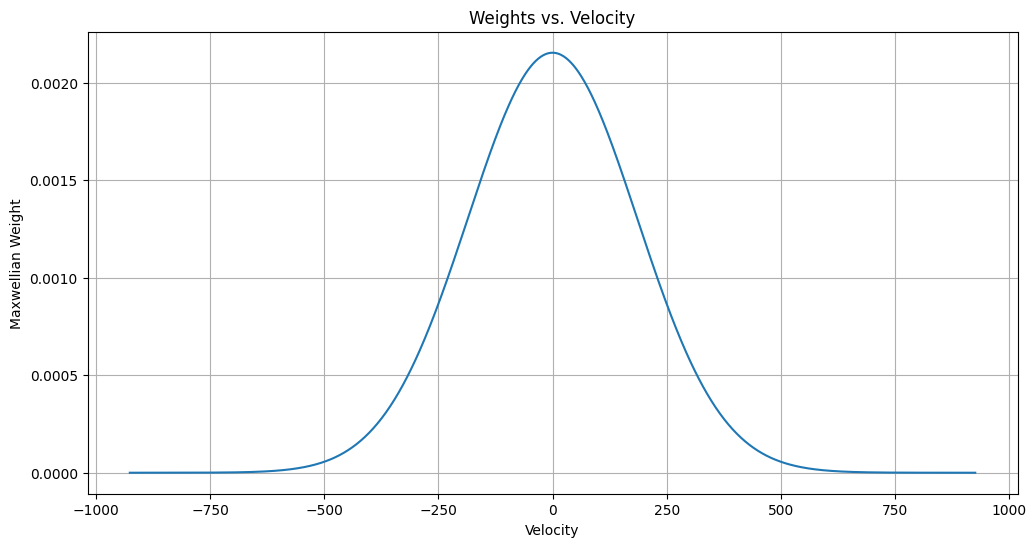

In [4]:
# Maxwell-Boltzmann distribution function
def Maxwellian(V):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-V**2 / (2 * sigma**2))
# Number of velocity points
nv = 1001
# Define a uniform velocity range (e.g., +/- 5 sigma)
v_min = -5.0 * sigma
v_max =  5.0 * sigma
v_values = np.linspace(v_min, v_max, nv)
# Each bin has the same width dv
dv_val = v_values[1] - v_values[0]
dv = np.full(nv, dv_val)
# Maxwell-Boltzmann distribution weights at each velocity
weights = Maxwellian(v_values)
# Verify that the total area under the curve approximates 1
total_area = np.sum(weights * dv)
print('Total area under Maxwellian:', total_area)


# Plotting
plt.figure(figsize=(12, 6))
plt.plot(v_values, weights)
plt.title('Weights vs. Velocity')
plt.xlabel('Velocity')
plt.ylabel('Maxwellian Weight')
plt.grid(True)
plt.show()

### 5c

The following cells use the analytical solution to solve the steady state solution with Doppler broadening.

use the parameters of fig 6 to plot fig 7, check the values of the detunings used

0.0222
0.0222
0.0222


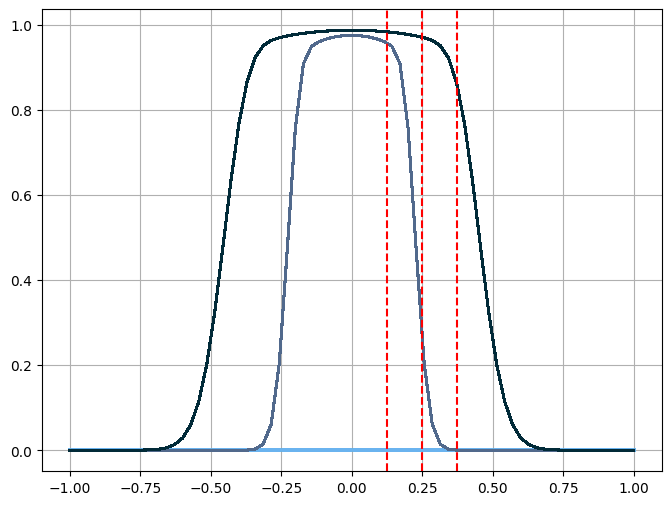

In [5]:
def transmission_vs_detuning_weakprobe_doppler(
        Om_p_mhz,         # probe Rabi freq in MHz
        Om_c_mhz,         # coupling Rabi freq in MHz
        delta_c_mhz=0.0,  # coupling detuning in MHz
        detuning_min=-100.0,  # range of probe detuning (MHz)
        detuning_max= 100.0,
        num_points=1001
    ):
    """
    Computes Transmission = e^(-OD) for a 3-level lambda system under
    the *weak probe* approximation, with Doppler summation included.

    We assume the standard expression for rho_{31} in the weak-probe limit:
        rho31 ~ (some numerator) / (some denominator)
    but we recast it to incorporate gamma12, gamma13, delta_p, delta_c, etc.
    Then we sum over velocity classes for the Doppler shift.

    Returns:
        delta_p_list (MHz), T_list (dimensionless)
    """
    # We'll define the "analytical" coherence formula (steady-state, weak-probe).
    # One conventional form (schematic) is:
    #
    #    rho31 = ( 2 * Omega_p/2 ) / [ (Gamma13 - i delta_p) +  (Omega_c^2/4)/(Gamma23 - i(delta_p - delta_c)) ]
    #
    # or any standard variant you used. You had something like:
    #    numerator = 2 * Omega_p ( delta_p - delta_c + i*gamma12 )
    #    denominator = Om_c^2 - 4( ... ) ...
    #
    # For clarity, let's define a small helper function:
    
    print (gamma12)

    def rho31_weak_probe(delta_p, delta_c, Omega_p, Omega_c):
        """
        Example: a typical EIT 3-level expression under weak probe.
        The exact form depends on your algebraic derivation, but we'll
        illustrate a common approximate formula.
        """
        # This version is similar to your earlier code snippet's logic:
        #   numerator   = 2 * Om_p * (delta_p - delta_c + i gamma12)
        #   denominator = Om_c^2 - 4 * (delta_p - delta_c + i gamma12)*(delta_p + i gamma13)
        #   rho31 = numerator / denominator
        #
        # Make sure Om_c, Om_p, gamma12, gamma13, etc. are consistent in units. 
        # We'll treat everything in MHz. Also recall Gamma3 is ~ 6 MHz (but you used 2*pi*6 in rad/s above).
        # For simplicity, let's keep everything "numerical in MHz" in the final expression.
        #
        numerator = 2 * Omega_p * (delta_p - delta_c + 1j * gamma12)
        denominator = (
            Omega_c * np.conjugate(Omega_c)
            - 4 * (delta_p - delta_c + 1j * gamma12) * (delta_p + 1j * gamma13)
        )
        return numerator / denominator
    
    # Create the array of probe detunings (in MHz)
    delta_p_list = np.linspace(detuning_min, detuning_max, num_points)

    T_list = []  # to hold Transmission values

    # We'll use the same approach:  OD = k_1 * Im(chi) * L
    # but we have to keep track that k_1 is in rad/m, and we want "Im(chi)" dimensionless.
    # Everything else is from your code.

    for dp in delta_p_list:
        # 2A) Accumulate the Doppler-averaged rho31
        rho31_sum = 0.0 + 0.0j
        
        for i_v, v in enumerate(v_values):
            # Doppler shift in MHz:
            # then /1e6 => MHz.
            doppler_shift_mhz = (k_1 * v) / (1e6)
            dp_eff = dp + doppler_shift_mhz  # effective probe detuning
            dc_eff = delta_c_mhz + doppler_shift_mhz # if you'd also shift coupling, do it here

            # Local coherence in the weak-probe limit
            rho31_loc = rho31_weak_probe(dp_eff, dc_eff, Om_p_mhz, Om_c_mhz)
            
            # Weighted by Maxwell–Boltzmann factor
            rho31_sum += rho31_loc * weights[i_v] * dv

        # 2B) Now we have the velocity-averaged rho31:
        rho31_avg = rho31_sum

        # 2C) Convert to susceptibility, then absorption, then OD
        #     from your prior formula: chi = (2 * N * rho31 * mu_13^2) / (eps0 * hbar * (Om_p in Hz))
        Om_p_hz = Om_p_mhz * 1e6
        chi = (2.0 * N * rho31_avg * (mu_13**2)) / (epsilon_0 * hbar * Om_p_hz)

        # Absorption coefficient alpha = k_1 * Im(chi).
        # => OD = alpha * L
        alpha = k_1 * np.imag(chi)  # 1/m
        OD = alpha * L

        # Transmission = e^(-OD)
        T = np.exp(-OD)
        T_list.append(T)

    return delta_p_list, np.array(T_list)

# Suppose these are globally defined or imported from your code:
# transmission_vs_detuning_weakprobe_doppler(...)
# Gamma3, etc.

def plot_EIT_window_doppler_multicoupling():
    """
    Scan the probe detuning Δ1 over some range for multiple coupling Rabi frequencies
    using the *weak-probe* Doppler-averaged formula, and plot all results.

    Custom blues color palette for 3 curves,
    plus red vertical lines at selected detunings.
    """

    # Example choices for probe (weak) and for scanning Δ₁
    Om_p_mhz  = 0.00001 * Gamma3  # ~ "weak" probe
    delta_c   = 0.0             # coupling on resonance

    dp_min = -1 * Gamma3
    dp_max =  1 * Gamma3

    # Coupling Rabi frequencies to compare
    Om_c_values = [0 * Gamma3, 10 * Gamma3, np.sqrt(200) * Gamma3]

    # Three custom blues from your earlier color scheme
    custom_colors = ["#6ab3ef", "#51698c", "#012a38"]

    # If you want vertical lines at these three detuning positions, just define them:
    # For example, let's say you want lines at detunings = 1/3 * Gamma3, 2/3 * Gamma3, and 1 * Gamma3
    vertical_lines = [1/8 * Gamma3, 2/8 * Gamma3, 3/8 * Gamma3 ]
    # You can change these to whichever x-values (in MHz) you want.

    plt.figure(figsize=(8, 6))

    # Loop over each coupling Rabi frequency
    for idx, Om_c_mhz in enumerate(Om_c_values):
        # Compute T vs. probe detuning
        dp_array, T_array = transmission_vs_detuning_weakprobe_doppler(
            Om_p_mhz=Om_p_mhz,
            Om_c_mhz=Om_c_mhz,
            delta_c_mhz=delta_c,
            detuning_min=dp_min,
            detuning_max=dp_max,
            num_points=71
        )

        # <-- CHANGED: Convert dp_array to dimensionless dp_array / Gamma3
        dp_scaled = dp_array / Gamma3  # dimensionless

        color_here = custom_colors[idx] if idx < len(custom_colors) else "blue"

        label_str = f"Om_c = {Om_c_mhz:.1f}"
        plt.plot(dp_scaled, T_array, label=label_str, color = color_here)

    # # Plot the vertical red lines
    for x_line in vertical_lines:
        plt.axvline(x=(x_line / Gamma3), color='r', linestyle='--', linewidth=1.5)

    # plt.xlabel(r"Probe Detuning $\Delta_1 / \Gamma_3$", fontsize=12)
    # plt.ylabel("Transmission", fontsize=12)
    # plt.ylim(0, 1)
    plt.grid(True)
    plt.savefig("5c.svg", format="svg")  # For SVG format
    plt.savefig("5c.eps", format="eps")  # For EPS format
    plt.show()

if __name__ == "__main__":
    plot_EIT_window_doppler_multicoupling()

Figure 6d: 

delta_1_values = [0 * Gamma3, 25 * Gamma3, 50 * Gamma3]

0.0222


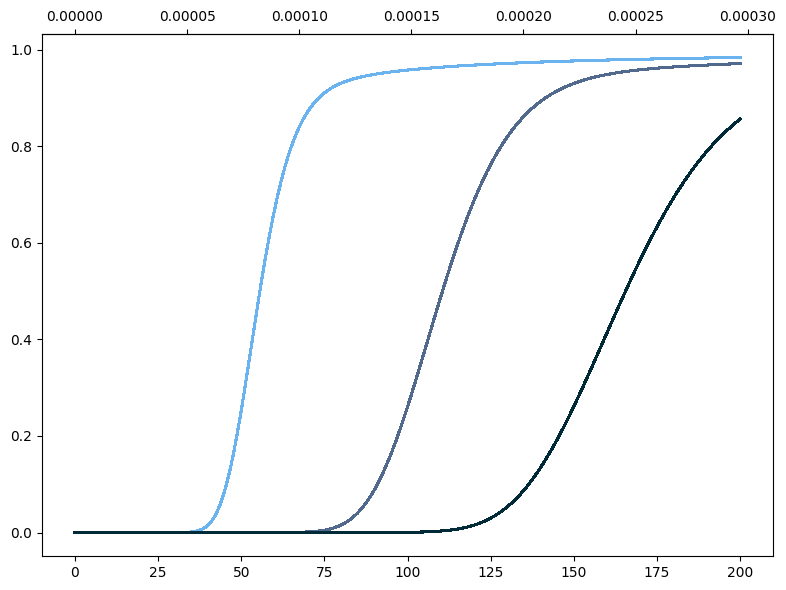

In [6]:
print (gamma12)

# --------------------------------------------------------------------
# 3) Single-pass function with Doppler broadening
#    (Replaces your 'single_pass_transmission' for Doppler-free)
# --------------------------------------------------------------------
def single_pass_transmission_doppler(Om_p_mhz, delta_1_mhz, delta_2_mhz, Om_c_mhz):
    """
    Computes T = exp(-OD) for a single pass,
    using a velocity-averaged (Doppler-broadened) rho31 in the same
    style as the 'weak-probe' expressions from your code.
    """
    rho31_sum = 0.0 + 0.0j

    for i_v, v in enumerate(v_values):
        # Doppler shift in MHz
        doppler_shift_mhz = (k_1 * v) / (1e6)
        d1_eff = delta_1_mhz + doppler_shift_mhz
        d2_eff = delta_2_mhz + doppler_shift_mhz  # if you want to shift coupling for co-propagation, do so here
        
        numerator = 2.0 * Om_p_mhz * ((d1_eff - d2_eff) + 1j * gamma12)
        denominator = (
            Om_c_mhz * np.conjugate(Om_c_mhz)
            - 4.0 * ((d1_eff - d2_eff) + 1j * gamma12) * (d1_eff + 1j * gamma13)
        )
        rho31_loc = numerator / denominator

        rho31_sum += rho31_loc * weights[i_v] * dv

    # Velocity-averaged coherence
    rho31_avg = rho31_sum

    # Susceptibility => OD => T
    Om_p_hz = Om_p_mhz * 1e6
    chi = (2.0 * N * rho31_avg * mu_13**2) / (epsilon_0 * hbar * Om_p_hz)
    alpha = k_1 * np.imag(chi)
    OD = alpha * L
    return np.exp(-OD)

# --------------------------------------------------------------------
# 4) Power / Rabi conversions for top axis
#    (Based on your earlier code snippet)
# --------------------------------------------------------------------
w0 = 71e-6  # beam waist (m), from your example
# For reference:
#   K_2 = (π * c * eps0 * (1e6)^2 * hbar^2 * w0^2) / (4 * mu_23^2)
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)

def x_forward(omega2_sq):
    """ 
    Convert dimensionless (Omega_2^2) * (Gamma3^2) => input power.
    If your code uses (Om_c_dimless^2) = (Om_c^2 / Gamma3^2), then
    we want P = K_2 * (Om_c^2).
    So if Om_c^2 = (Om_c_dimless^2)*(Gamma3^2), then P = K_2*(Gamma3^2)*Om_c_dimless^2.
    """
    return K_2 * omega2_sq * (Gamma3**2)

def x_inverse(power_value):
    """
    Inverse of x_forward, so if P = K_2*(Gamma3^2)*(Om_c_dimless^2),
    then (Om_c_dimless^2) = P / [K_2*(Gamma3^2)].
    """
    return power_value / (K_2 * (Gamma3**2))

# --------------------------------------------------------------------
# 5) Main plotting function with double x-axis
# --------------------------------------------------------------------
def plot_omega1out_sq_vs_omega2in_sq(
    Om_p_mhz          = 0.001,
    delta_1_list_mhz  = [-2.0, 0.0, 2.0],
    delta_2_mhz       = 0.0,
    Om_c_dimless_min  = 0.0,
    Om_c_dimless_max  = 5.0,
    num_points        = 300
):
    """
    Plots (|Omega_1,out|^2 / |Omega_1,in|^2) vs. (Om_c_dimless^2) with Doppler broadening.
    'Om_c_dimless' = Om_c / Gamma3.
    We'll add a secondary x-axis on top that converts to input power for Omega_2.
    """

    Om_c_dimless_array = np.linspace(Om_c_dimless_min, Om_c_dimless_max, num_points)

    fig, ax1 = plt.subplots(figsize=(8,6))

    # Some color/legend settings
    cmap = plt.cm.Blues
    color_min, color_max = 0.2, 0.8
    n_curves = len(delta_1_list_mhz)
    custom_colors = ["#6ab3ef", "#51698c", "#012a38"]  # up to 3 curves

    for idx, delta_1_mhz in enumerate(delta_1_list_mhz):
        T_curve = []
        x_values = []
        for Om_c_dimless in Om_c_dimless_array:
            # Convert dimensionless -> actual (MHz)
            Om_c_mhz = Om_c_dimless

            # Call Doppler-broadened single-pass
            T_point = single_pass_transmission_doppler(
                Om_p_mhz, delta_1_mhz, delta_2_mhz, Om_c_mhz
            )
            T_curve.append(T_point)
            # x-axis: (Om_c / Gamma3)^2
            x_values.append(Om_c_dimless**2 / Gamma3**2)

        # pick a color from custom or colormap
        if n_curves > 1:
            fraction = idx / (n_curves - 1)
        else:
            fraction = 0.5
        adjusted_fraction = color_min + fraction*(color_max-color_min)
        line_color = cmap(adjusted_fraction)
        if idx < len(custom_colors):
            line_color = custom_colors[idx]

        label_str = rf"$\Delta_1 = {delta_1_mhz / Gamma3:.3f}\,\Gamma_3$"
        ax1.plot(x_values, T_curve, label=label_str, color=line_color)

    # set y-limits, etc.
    # ax1.set_ylim([0, 1])
    #ax1.set_xlabel(r"$(\Omega_{2,\mathrm{in}} / \Gamma_3)^2$")
    #ax1.set_ylabel(r"$|\Omega_{1,\mathrm{out}}|^2 / |\Omega_{1,\mathrm{in}}|^2$")

    # Secondary x-axis for input power
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    #ax_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # ax1.legend()
    plt.tight_layout()
    plt.savefig("5d.svg", format="svg")  # For SVG format
    plt.savefig("5d.eps", format="eps")  # For EPS format
    plt.show()

# --------------------------------------------------------------------
# 6) Example usage
# --------------------------------------------------------------------
if __name__ == "__main__":
    # Example: a weak probe of 0.001 (in 'MHz' numeric sense)
    Om_p_example = 0.00001 * Gamma3
    delta_2_example = 0.0

    # We'll see how the final probe amplitude depends on coupling power
    # for three different probe detunings:
    delta_1_values = [1/8 * Gamma3, 2/8 * Gamma3, 3/8 * Gamma3]

    plot_omega1out_sq_vs_omega2in_sq(
        Om_p_mhz         = Om_p_example,
        delta_1_list_mhz = delta_1_values,
        delta_2_mhz      = delta_2_example,
        Om_c_dimless_min = 0.0,
        Om_c_dimless_max = np.sqrt(200) * Gamma3, 
        num_points       = 400
    )

### 5a

1
gamma12_orig = 0.0222 MHz
gamma12 = 0.0222 MHz
1000
gamma12_orig = 0.0222 MHz
gamma12 = 22.2 MHz
5000
gamma12_orig = 0.0222 MHz
gamma12 = 111 MHz


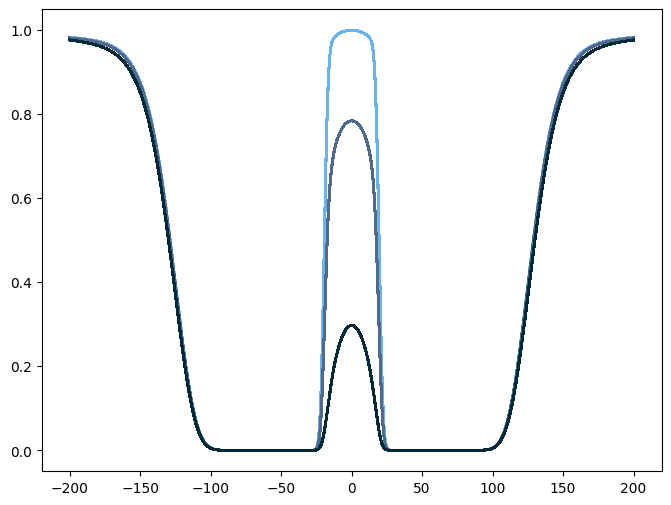

In [7]:
# --------------------------------------------------------------------
# 2) Weak-probe EIT with variable gamma12, but fixed gamma13
# --------------------------------------------------------------------
def transmission_vs_detuning_weakprobe_doppler_gamma12(
    Om_p_mhz,
    Om_c_mhz,
    gamma12_val,     
    delta_c_mhz=0.0,
    detuning_min=-100.0,
    detuning_max=100.0,
    num_points=1001
):
    """
    Computes Transmission = e^(-OD) under the weak-probe approximation
    with Doppler broadening, letting gamma12 be user-specified and
    keeping gamma13 fixed at gamma13_orig.
    """

    def rho31_weak_probe(delta_p, delta_c, Omega_p, Omega_c):
        # We use gamma12_val for gamma12, but gamma13_orig stays fixed.
        i = 1j
        numerator = 2 * Omega_p * ((delta_p - delta_c) + i * gamma12_val)
        denominator = (
            Omega_c * np.conjugate(Omega_c)
            - 4 * ((delta_p - delta_c) + i * gamma12_val) * (delta_p + i * gamma13_orig)
        )
        return numerator / denominator

    delta_p_list = np.linspace(detuning_min, detuning_max, num_points)
    T_list = []

    # Convert probe Rabi freq (MHz) -> Hz
    Om_p_hz = Om_p_mhz * 1e6

    for dp in delta_p_list:
        rho31_sum = 0.0 + 0.0j

        for i_v, v in enumerate(v_values):
            # Doppler shift in MHz
            doppler_shift_mhz = (k_1 * v) / (1e6)
            dp_eff = dp + doppler_shift_mhz
            dc_eff = delta_c_mhz + doppler_shift_mhz  # if you'd also shift coupling, do it here

            # local coherence
            rho31_loc = rho31_weak_probe(dp_eff, dc_eff, Om_p_mhz, Om_c_mhz)
            rho31_sum += rho31_loc * weights[i_v] * dv

        # velocity-averaged rho31
        rho31_avg = rho31_sum

        # susceptibility => alpha => OD => Transmission
        chi = (2.0 * N * rho31_avg * mu_13**2) / (epsilon_0 * hbar * Om_p_hz)
        alpha = k_1 * np.imag(chi)
        OD = alpha * L
        T_list.append(np.exp(-OD))

    # divide by Gamma3 to make dimensionless
    delta_p_list = delta_p_list / Gamma3
    return delta_p_list, np.array(T_list)

# --------------------------------------------------------------------
# 3) Plot function: scan multiple gamma12 scale factors
# --------------------------------------------------------------------
def plot_EIT_window_doppler_multi_gamma12():
    """
    For a fixed (weak) probe and coupling field, vary gamma12 by scale
    factors. Keep gamma13 fixed at original gamma13_orig.

    Color code each curve with custom blue shades.
    """
    # Let’s define the standard Rabi frequencies
    Om_p_mhz  = 0.0001 * Gamma3   # "weak" probe
    Om_c_mhz  = 100.0  * Gamma3   # coupling
    delta_c   = 0.0

    # Range of probe detuning
    dp_min = -200 * Gamma3
    dp_max =  200 * Gamma3

    # We'll pick several scale factors for gamma12
    scale_factors = [1, 1000, 5000]

    # Our custom blues
    custom_colors = ["#6ab3ef", "#51698c", "#012a38"]

    plt.figure(figsize=(8,6))

    for idx, sf in enumerate(scale_factors):
        # Pick color from custom blues if available
        if idx < len(custom_colors):
            plot_color = custom_colors[idx]
        else:
            plot_color = "blue"  # fallback if more scale_factors than colors

        # Scaled gamma12
        print(sf)
        print(f"gamma12_orig = {gamma12_orig:.3g} MHz")
        this_gamma12 = sf * gamma12_orig
        print(f"gamma12 = {this_gamma12:.3g} MHz")

        # Now compute T vs. detuning
        dp_array, T_array = transmission_vs_detuning_weakprobe_doppler_gamma12(
            Om_p_mhz=Om_p_mhz,
            Om_c_mhz=Om_c_mhz,
            gamma12_val=this_gamma12,
            delta_c_mhz=delta_c,
            detuning_min=dp_min,
            detuning_max=dp_max,
            num_points=1001
        )

        label_str = f"γ12 = {sf:.0f}×({gamma12_orig:.3g} MHz)"
        plt.plot(dp_array, T_array, label=label_str, color=plot_color)

    # plt.title("EIT Window, Doppler-Averaged, Varying γ12 (Custom Blues)", fontsize=14)
    # plt.xlabel("Probe Detuning Δ₁ (MHz)", fontsize=12)
    # plt.ylabel("Transmission", fontsize=12)
    # plt.grid(True)
    plt.savefig("5a.svg", format="svg")  # For SVG format
    plt.savefig("5a.eps", format="eps")  # For EPS format
    # plt.legend()
    plt.show()

# --------------------------------------------------------------------
# 4) Main
# --------------------------------------------------------------------
if __name__ == "__main__":
    plot_EIT_window_doppler_multi_gamma12()

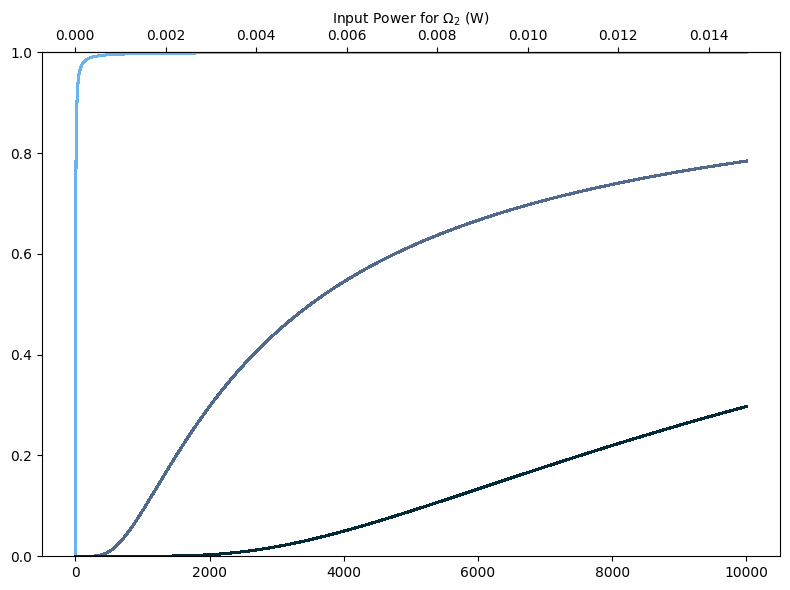

In [9]:
# --------------------------------------------------------------------
# 2) Single-pass Doppler-broadened function that allows user-specified gamma12
# --------------------------------------------------------------------
def single_pass_transmission_doppler_gamma12(Om_p_mhz, delta_1_mhz, delta_2_mhz, Om_c_mhz, gamma12_val):
    """
    Computes T = exp(-OD) for a single pass, using a velocity-averaged
    (Doppler-broadened) rho31 in the 'weak-probe' style expression.

    gamma12_val is a user-specified ground-state decoherence (MHz),
    while gamma13_orig is held fixed for the excited-state decoherence.
    """
    rho31_sum = 0.0 + 0.0j
    for i_v, v in enumerate(v_values):
        # Doppler shift (MHz)
        doppler_shift_mhz = (k_1 * v) / ( 1e6)
        d1_eff = delta_1_mhz + doppler_shift_mhz
        d2_eff = delta_2_mhz + doppler_shift_mhz

        # Weak-probe style numerator & denominator
        numerator = 2.0 * Om_p_mhz * ((d1_eff - d2_eff) + 1j * gamma12_val)
        denominator = (
            Om_c_mhz * np.conjugate(Om_c_mhz)
            - 4.0 * ((d1_eff - d2_eff) + 1j * gamma12_val) * (d1_eff + 1j * gamma13_orig)
        )
        rho31_loc = numerator / denominator

        rho31_sum += rho31_loc * weights[i_v] * dv

    # Velocity-averaged coherence
    rho31_avg = rho31_sum

    # Convert to OD => T
    Om_p_hz = Om_p_mhz * 1e6
    chi = (2.0 * N * rho31_avg * (mu_13**2)) / (epsilon_0 * hbar * Om_p_hz)
    alpha = k_1 * np.imag(chi)
    OD = alpha * L
    return np.exp(-OD)

# --------------------------------------------------------------------
# 3) Power <-> dimensionless Omega_c^2 conversions (optional)
# --------------------------------------------------------------------
w0 = 71e-6
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)

def x_forward(omega2_sq):
    """
    Convert dimensionless (Om_c_dimless^2) -> input power (W):
       P = K_2 * (Gamma3^2) * (Om_c_dimless^2)
    """
    return K_2 * (Gamma3**2) * omega2_sq

def x_inverse(power_value):
    """
    Inverse to x_forward:
       (Om_c_dimless^2) = P / [K_2 * (Gamma3^2)]
    """
    return power_value / (K_2 * (Gamma3**2))

# --------------------------------------------------------------------
# 4) Plot single-pass curves vs (Om_c/Gamma3)^2 for multiple gamma12
# --------------------------------------------------------------------
def plot_single_pass_vs_omega2in_sq_multi_gamma12(
    Om_p_mhz         = 0.001,
    delta_1_mhz      = 0.0,
    delta_2_mhz      = 0.0,
    scale_factors    = [1.0, 500.0, 1000.0],
    Om_c_dimless_min = 0.0,
    Om_c_dimless_max = 5.0,
    num_points       = 200
):
    """
    For multiple gamma12 scale factors, plot Transmission vs. (Om_c/Gamma3)^2,
    using the Doppler-broadened single-pass approach.

    Each curve uses single_pass_transmission_doppler_gamma12(...) with
    gamma12 = scale_factor * gamma12_orig, and color-codes with custom blues.
    """

    # Custom blues color palette
    custom_colors = ["#6ab3ef", "#51698c", "#012a38"]

    # Create dimensionless coupling array
    Om_c_dimless_array = np.linspace(Om_c_dimless_min, Om_c_dimless_max, num_points)

    plt.figure(figsize=(8,6))

    for idx, sf in enumerate(scale_factors):
        # Choose color
        if idx < len(custom_colors):
            color_here = custom_colors[idx]
        else:
            color_here = "blue"

        this_gamma12 = sf * gamma12_orig
        T_curve = []
        x_axis = []
        for Om_c_dimless in Om_c_dimless_array:
            Om_c_mhz = Om_c_dimless * Gamma3
            T_val = single_pass_transmission_doppler_gamma12(
                Om_p_mhz, delta_1_mhz, delta_2_mhz, Om_c_mhz, this_gamma12
            )
            T_curve.append(T_val)
            x_axis.append(Om_c_dimless**2)  # (Om_c/Gamma3)^2

        label_str = rf"$\gamma_{{12}} = {sf}\times({gamma12_orig:.3g}\,\mathrm{{MHz}})$"
        plt.plot(x_axis, T_curve, label=label_str, color=color_here)

    # plt.xlabel(r"$(\Omega_{2,\mathrm{in}}/\Gamma_{3})^2$")
    # plt.ylabel(r"$|\Omega_{1,\mathrm{out}}|^2 / |\Omega_{1,\mathrm{in}}|^2$")
    plt.ylim(0,1)
    # plt.grid(True)

    # Secondary x-axis for power
    ax = plt.gca()
    ax_top = ax.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # plt.title(
    #     f"Single-pass EIT vs $(\\Omega_2/\\Gamma_3)^2$, varying $\gamma_{{12}}$;"
    #     f" $\Delta_1={delta_1_mhz}$ MHz"
    # )
    # plt.legend()
    plt.tight_layout()
    plt.savefig("5b.svg", format="svg")  # For SVG format
    plt.savefig("5b.eps", format="eps")  # For EPS format
    plt.show()

# --------------------------------------------------------------------
# 5) Main Demo
# --------------------------------------------------------------------
if __name__ == "__main__":
    # Example usage: same scale_factors as before
    plot_single_pass_vs_omega2in_sq_multi_gamma12(
        Om_p_mhz         = 0.00001 * Gamma3,   # "weak" probe
        delta_1_mhz      = 0.0,
        delta_2_mhz      = 0.0,
        scale_factors    =[1, 1000, 5000],
        Om_c_dimless_min = 0.0,
        Om_c_dimless_max = 100,
        num_points       = 70
    )